In [ ]:
## emulator training data
# input5paras: 'C:/Users/cw18831/OneDrive - University of Bristol/Documents/Research/KAERI/Emulator code/Emulator/2015_Bristol_5D_v001/orig/Input/Samp_orbits_tdum.res'), sep=" ", header=TRUE)
# outputpatterns:C:/Users/cw18831/OneDrive - University of Bristol/Documents/Research/KAERI/Emulator code/Emulator/2015_Bristol_5D_v001/orig/Output/dTeq/LT2000/', paste("dTeq_temp_mm_1_5m_ann_", 

% 这个脚本建于已经read并write了所有temp和precip数据的R脚本之后，直接读取所有（100y）的模型输出数据。这一步可以被更改。
# 添加必要package

In [3]:
#%autoreload
#%reload_ext autoreload
import pandas as pd
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import os
import h5py
# some user defined functions
from pca import PCA
from GP_C import GP_C
import compute_covariance as cov_mat
import seaborn as sns

path = 'training_ori/'
os.chdir('../' + path)
emu_path = 'emulator/'
if not os.path.exists(emu_path):
    os.makedirs(emu_path)

# 定义hyper parameters

In [4]:
# number of Principal Components to take into account
nkeep = 20

# length scale and nugget hyperparameter values
# higher length scale means smoother functions, higher nugget means more noise
hp = pd.DataFrame({
    'l.esinw': np.repeat(3.65, nkeep),
    'l.ecosw': [3.31] * nkeep,
    'l.obl': [5.22] * nkeep,
    'l.co2': [3.5] * nkeep,
    'l.icevol': [1.2] * nkeep,
    'nugget': [0.001] * nkeep
})

# The way the pe_c routine takes hp is not okay: it requires a matrix shaped this way
hp = hp.T

print("we keep ",nkeep," PCs, ")
print("the hyper parameter shape:",hp.shape)
print("every PC has the same set of HP, an example:")
print(hp.iloc[:, 0])


we keep  20  PCs, 
the hyper parameter shape: (6, 20)
every PC has the same set of HP, an example:
l.esinw     3.650
l.ecosw     3.310
l.obl       5.220
l.co2       3.500
l.icevol    1.200
nugget      0.001
Name: 0, dtype: float64


#  读取五个变量并且normalize -地球轨道，CO2，ice

##  读取五个变量

In [5]:
# 读取文件
cont_paramdat = pd.read_csv('emul_input_5variables.txt', sep='\s+', header=0)

# 获取数据维度
cont_param_dim = cont_paramdat.shape

# 打印列名以检查是否存在 
print(cont_paramdat.columns)

# 提取各列
obliquity = cont_paramdat['obliquity']
esinw = cont_paramdat['esinw']
ecosw = cont_paramdat['ecosw']
co2 = cont_paramdat['co2_ppm']
ice = cont_paramdat['ice']

Index(['esinw', 'ecosw', 'obliquity', 'co2_ppm', 'ice'], dtype='object')


## normalized数据并新建一个DataFrame保存

In [6]:
import xarray as xr


obliquity_sum = obliquity.sum()
esinw_sum = esinw.sum()
ecosw_sum = ecosw.sum()
co2_sum = co2.sum()
ice_sum = ice.sum()

paras_normalized = pd.DataFrame(columns=[ 'esinw_norm', 'ecosw_norm', 'obliquity_norm', 'co2_ppm_norm', 'ice_norm'])
paras_normalized['esinw_norm'] = esinw / esinw_sum
paras_normalized['ecosw_norm'] = ecosw / ecosw_sum
paras_normalized['obliquity_norm'] = obliquity / obliquity_sum
paras_normalized['co2_ppm_norm'] = co2 / co2_sum
paras_normalized['ice_norm'] = ice / ice_sum

paras_normalized.info()

# Create a dataset with the sums of the parameters
data = {
    'esinw_sum': esinw_sum,
    'ecosw_sum': ecosw_sum,
    'obliquity_sum': obliquity_sum,
    'co2_sum': co2_sum,
    'ice_sum': ice_sum
}

# Convert the dictionary to an xarray Dataset
ds = xr.Dataset(data)

# Save the dataset to a NetCDF file，用作后面的prediction的inputd normalize
ds.to_netcdf(emu_path+'emul_input_5variables_sum.nc')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   esinw_norm      100 non-null    float64
 1   ecosw_norm      100 non-null    float64
 2   obliquity_norm  100 non-null    float64
 3   co2_ppm_norm    100 non-null    float64
 4   ice_norm        100 non-null    float64
dtypes: float64(5)
memory usage: 4.0 KB


# 读取模型输出数据（temp，precip) 12x100x201x201 - month x exp x lat x lon

## 读取温度数据

In [8]:

month=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

## 读取温度数据

# Initialize an empty array to store temperature data for all months
temp_all_mon = np.empty((12, *(100,201,201)))

month_index = 0
# Open the NetCDF file
for mon in month:
    temp_file_path = '/Users/bo20541/Library/CloudStorage/OneDrive-UniversityofBristol/TONIC-Oligocene/CLISEMv1.0/emulator_8_icearea/temp_'+mon+'_all_aism.nc'
    temp_file = Dataset(temp_file_path, mode='r')  # 'r' for read mode
    # Print the file information
    #print("Variables:", temp_file.variables.keys())

    # Extract data from a specific variable (e.g., 'temperature')
    temp_tmp = temp_file.variables['model_output_temp'][:,:,:]
    #print("temperature data shape:",temp_tmp.shape)

    # Store the temperature data for all months
    temp_all_mon[month_index] = temp_tmp
    month_index += 1

    # Close the file
    temp_file.close()
    
print("temperature data for all months shape:",temp_all_mon.shape)

temperature data for all months shape: (12, 100, 201, 201)


# 进行PCA处理
 产生几个components（可以理解为维度）

In [9]:

# Perform PCA for each month and store the results
temp_pca_all_months = []

# Remove the PCA file if it already exists
if os.path.exists(emu_path+"PCA.h5"):
    os.remove(emu_path+"PCA.h5")

for month_index in range(12):
    temp_pca = PCA(temp_all_mon[month_index, :, :, :].transpose(1, 2, 0), nkeep)
    temp_pca_all_months.append(temp_pca)
    # Save the PCA results of temp_pca to a file
    with h5py.File(emu_path+"PCA.h5", "a") as file:
        group = file.create_group(f"month_{month_index + 1:02}")
        for key, value in temp_pca.items():
            if isinstance(value, np.ndarray) or isinstance(value, (int, float)):
                group.create_dataset(key, data=value)  # Save matrix
            else:
                group.attrs[key] = str(value)  # Convert non-array types to strings before saving as attributes for key, value in temp_pca.items():


# mean: mean of each grid
# PCA: the original PCA results 主成分
# scaled_amps: scaled amplitude of each PC。
# amps: amplitude of each PC 每个月份数据的主成分得分。
# d: 

shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)
shape of U:  (40401, 100)
shape of s:  (100,)
shape of Vt:  (100, 100)


# 进行GP处理

### 对于cov_mat function的画图说明

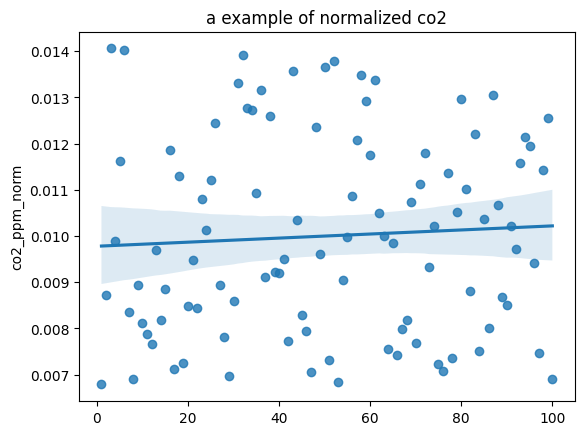

Variable 'RR' is not read from cov_mat.


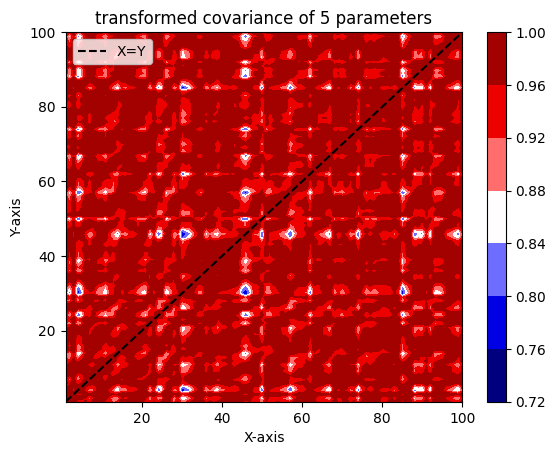

In [31]:
## test the covariance matrix
%autoreload 2
import compute_covariance as cov_mat
import matplotlib.pyplot as plt

## need to be modified in the cov_mat function
R = cov_mat.cov_mat(hp.iloc[:, 0], paras_normalized, paras_normalized)

# a example to visualize the function of cov_mat
x = np.arange(1, len(paras_normalized['co2_ppm_norm']) + 1)

# First figure
plt.figure()
sns.regplot(x=x, y=paras_normalized['co2_ppm_norm'])
plt.title('a example of normalized co2')
plt.show()

if 'RR' in locals():
    plt.figure()
    plt.contourf(x, x, RR[:, :, 3], cmap='seismic')
    plt.colorbar()
    plt.plot(x, x, 'k--', label='X=Y')  # Add X=Y line
    plt.title('transformed covariance matrix of CO2')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()
else:
    print("Variable 'RR' is not read from cov_mat.")

# Third figure
plt.figure()
plt.contourf(x, x, R[:, :], cmap='seismic')
plt.colorbar()
plt.plot(x, x, 'k--', label='X=Y')  # Add X=Y line
plt.title('transformed covariance of 5 parameters')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


## GP - Calibration
 get the E_list which contains mean, PCA ...

In [ ]:

#%autoreload
import GP_C as GP_C
import h5py

# define the regress method
regress = 'linear'

# Print a summary of temp_pca
# Create a new group for each 'nkeep' in the HDF5 file
with h5py.File(emu_path+"GPList.h5", "w") as file: 
    # loop of months
    for month_index in range(12):
        # loop of nkeep of PCAs
        # amps[n,nkeep] 
        for i in range(nkeep):
            GPList = GP_C.GP_C(paras_normalized, temp_pca_all_months[month_index]['amps'][:, i], hp.iloc[:, i], regress=regress)
            group = file.create_group(f"month_{month_index + 1:02}/PC_{i+1:02}")
            for key, value in GPList.items():
                if isinstance(value, np.ndarray):
                    group.create_dataset(key, data=value)  # Save matrix
                else:
                    group.attrs[key] = str(value)  # Convert non-array types to strings before saving as attributes
            group.attrs['regress'] = regress  # Store regress as a string

# check the keys of the dictionary
print(GPList.keys())
print(GPList['lambda'])
print("shape of X is",GPList['X'].shape)
print("shape of Y is",GPList['Y'].shape)

dict_keys(['betahat', 'sigma_hat_2', 'R', 'Rt', 'muX', 'X', 'Y', 'lambda', 'e', 'funcmu', 'R1tX', 'log_REML', 'log_pen_REML', 'covar', 'nbrr'])
{'l.esinw': 3.65, 'l.ecosw': 3.31, 'l.obl': 5.22, 'l.co2': 3.5, 'l.icevol': 1.2, 'nugget': 0.001, 'epsilon': 1.0}
shape of X is (100, 5)
shape of Y is (100,)


### testing code for GP_C
‘’‘
%autoreload
X = paras_normalized
i=0
Y = temp_pca['amps'][:, i]
lambda_ = hp.iloc[:, i]
name = 'linear'
#
if not isinstance(Y, np.ndarray):
    Y = np.array(Y)
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)
def get_funcmu(name):
    if name == "linear":
        return lambda x: x  # Example linear function
print(X.shape)
print(Y.shape)
muX = np.apply_along_axis(get_funcmu(name), 1, X)
print(muX.shape)
nq = muX.shape[1]
n = X.shape[0]
nn = X.shape[1]
nbr = n - nq
nbrr = n - nq - 2
covar=np.exp
R = cov_mat.cov_mat(lambda_, X, X)


Rt = R + np.diag(np.full(n, lambda_['nugget']))
R1tX = np.linalg.solve(Rt, muX)
dummy1 = muX.T @ R1tX
print(dummy1)
K = np.linalg.solve(dummy1, muX.T)
betahat = K @ np.linalg.solve(Rt, Y)
dummy2 = Y - muX @ betahat
e = np.linalg.solve(Rt, dummy2)
sigma_hat_2 = (dummy2.T @ e) / nbrr
sigma_hat_2 = np.atleast_2d(sigma_hat_2)
M = (lambda_['nugget'] ** 2) * (dummy2.T @ np.linalg.solve(Rt.T @ Rt, dummy2)) / n
Minfty = (dummy2.T @ dummy2) / n
log_REML = -0.5 * (nbr * np.log(np.diag(sigma_hat_2)) + np.log(np.linalg.det(Rt)) + np.log(np.linalg.det(muX.T @ R1tX)))

if 'epsilon' not in lambda_:
    lambda_['epsilon'] = 1

log_pen_REML = log_REML - 2 * (M / Minfty / lambda_['epsilon'])

print(log_pen_REML)
#test=GP_C(X, Y, lambda_, regress)
’‘’